# BIG DATA ANALYSIS : 딥러닝을 이용한 주시가격 예측
## RNN을 이용한 주시가격 예측
---

In [76]:
import sys
!{sys.executable} -m pip install tensorflow


In [102]:
#관련 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import utils
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas_datareader.data as web

tf.random.set_seed(777) 

## 1. 주식 데이터 로드

In [165]:
df = web.DataReader("005930.KS", "yahoo", "2018-01-01", "2020-11-20")


## 2. EDA

In [166]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-03,52560.0,51420.0,52540.0,51620.0,10013500.0,32073.728516
2018-01-04,52180.0,50640.0,52120.0,51080.0,11695450.0,31738.205078
2018-01-05,52120.0,51200.0,51300.0,52120.0,9481150.0,32384.400391
2018-01-08,52520.0,51500.0,52400.0,52020.0,8383650.0,32322.263672
2018-01-09,51720.0,49980.0,51460.0,50400.0,18013600.0,31315.691406


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 708 entries, 2018-01-03 to 2020-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       708 non-null    float64
 1   Low        708 non-null    float64
 2   Open       708 non-null    float64
 3   Close      708 non-null    float64
 4   Volume     708 non-null    float64
 5   Adj Close  708 non-null    float64
dtypes: float64(6)
memory usage: 38.7 KB


In [168]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,708.000000,708.000000,708.000000,708.000000,7.080000e+02,708.000000
mean,49910.112994,48864.138418,49403.121469,49385.423729,1.470608e+07,47663.158385
std,5729.245576,5609.264434,5686.644046,5666.111521,8.303756e+06,7696.617391
min,37600.000000,36850.000000,37450.000000,37450.000000,0.000000e+00,27774.033203
25%,45800.000000,44850.000000,45200.000000,45350.000000,9.230368e+06,43950.000000
50%,48990.000000,47650.000000,48250.000000,48400.000000,1.263644e+07,46900.000000
75%,53200.000000,52000.000000,52650.000000,52700.000000,1.777495e+07,52325.000000
max,67000.000000,65600.000000,67000.000000,66300.000000,6.468130e+07,66300.000000


In [169]:
df.tail(n=7)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-12,61400.0,60700.0,61000.0,61000.0,19800573.0,61000.0
2020-11-13,63200.0,61000.0,61300.0,63200.0,31508829.0,63200.0
2020-11-16,66700.0,63900.0,64000.0,66300.0,36354334.0,66300.0
2020-11-17,67000.0,65600.0,67000.0,65700.0,30204089.0,65700.0
2020-11-18,66200.0,64700.0,65700.0,64800.0,22963790.0,64800.0
2020-11-19,64800.0,63900.0,64100.0,64600.0,16590290.0,64600.0
2020-11-20,65200.0,63900.0,63900.0,64700.0,15068682.0,64700.0


## 3. 전처리

In [170]:
df = df[['Open', 'High', 'Low', 'Close']]

data = df.to_numpy()
split = len(data) - int(len(data)*0.3)
print(split)
print(df.iloc[split])
train = data[:split]
test = data[split:]

496
Open     59500.0
High     59600.0
Low      58900.0
Close    59000.0
Name: 2020-01-15 00:00:00, dtype: float64


In [171]:
test[-1]

array([63900., 65200., 63900., 64700.])

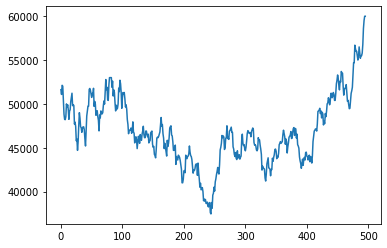

In [172]:
import matplotlib.pyplot as plt
# 조정종가 기준으로 값 확인
plt.plot(train[:,-1])

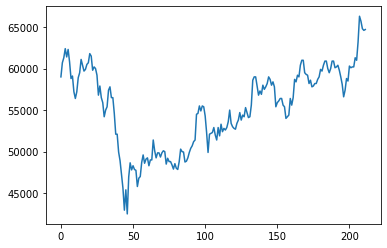

In [173]:
plt.plot(test[:,-1])

In [174]:

#데이터를 스케일링 해서 학습 효과 향상
transformer = MinMaxScaler()
train = transformer.fit_transform(train)
test = transformer.transform(test)

sequence_length = 5
window_length = sequence_length + 1

x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1, :])
    y_train.append(window[-1, [-1]])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1, :])
    y_test.append(window[-1, [-1]])
x_test = np.array(x_test)
y_test = np.array(y_test)


print(x_train.shape)
print(y_train.shape)


(491, 5, 4)
(491, 1)


In [175]:
df.tail(n=10)

,Open,High,Low,Close
Date,,,,
2020-11-09,60700.0,60900.0,60100.0,60200.0
2020-11-10,60500.0,60500.0,59500.0,60200.0
2020-11-11,60700.0,61400.0,60400.0,61300.0
2020-11-12,61000.0,61400.0,60700.0,61000.0
2020-11-13,61300.0,63200.0,61000.0,63200.0
2020-11-16,64000.0,66700.0,63900.0,66300.0
2020-11-17,67000.0,67000.0,65600.0,65700.0
2020-11-18,65700.0,66200.0,64700.0,64800.0
2020-11-19,64100.0,64800.0,63900.0,64600.0


In [178]:
x_test[-1]

array([[1.03921569, 1.09401709, 1.04772234, 1.14190687],
       [1.15686275, 1.24358974, 1.17353579, 1.27937916],
       [1.2875817 , 1.25641026, 1.2472885 , 1.25277162],
       [1.23093682, 1.22222222, 1.20824295, 1.21286031],
       [1.16122004, 1.16239316, 1.17353579, 1.20399113]])

In [179]:
transformer.inverse_transform([[1.16122004, 1.16239316, 1.17353579, 1.20399113]])

array([[64099.999918 , 64799.999944 , 63899.9999595, 64599.9999815]])

## 4. 모델 학습 및 검증

In [180]:
##########모델 학습
##########모델 검증

input = Input(shape=(sequence_length, 4))
net = LSTM(units=256)(input) 
net = Dense(units=256, activation='relu')(net)
net = Dense(units=1)(net)
model = Model(inputs=input, outputs=net)

model.summary()

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test)) 


Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 5, 4)]            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               267264    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 257       
Total params: 333,313
Trainable params: 333,313
Non-trainable params: 0
_________________________________________________________________
Train on 491 samples, validate on 207 samples
Epoch 1/50
491/491 [==============================] - 2s 4ms/sample - loss: 0.0708 - val_loss: 0.0102
Epoch 2/50
491/491 [==============================] - 0s 376us/sample - loss: 0.0074 - val_loss: 0.0208

## 5. 결과확인

In [181]:
x_test.shape

(207, 5, 4)

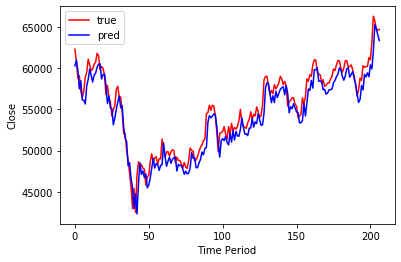

In [182]:
##########모델 예측

y_test_inverse = []
for y in y_test:
    inverse = transformer.inverse_transform([[0, 0, 0, y[0]]])
    y_inverse = inverse.flatten()[-1]
    y_test_inverse.append(y_inverse)

y_predict = model.predict(x_test)
y_predict_inverse = []
for y in y_predict:
    inverse = transformer.inverse_transform([[0, 0, 0, y[0]]])
    y_inverse = inverse.flatten()[-1]
    y_predict_inverse.append(y_inverse)

import matplotlib.pyplot as plt
plt.plot(y_test_inverse, c="r", label="true")
plt.plot(y_predict_inverse, c="b", label="pred")
plt.xlabel('Time Period')
plt.ylabel('Close')
plt.legend()
plt.show()


## 7. 다음 주의 주가는 과연!!

In [183]:
df = web.DataReader("005930.KS", "yahoo", "2020-11-19", "2020-11-25")
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-11-19,64800,63900,64100,64600,16590290,64600
2020-11-20,65200,63900,63900,64700,15068682,64700
2020-11-23,67800,64700,64800,67500,27134398,67500
2020-11-24,69500,67000,67900,67700,32158235,67700
2020-11-25,68300,66500,67900,66600,29736832,66600


In [184]:
df = df[['Open', 'High', 'Low', 'Close']]


x_test = df.to_numpy()

x_test = transformer.transform(x_test)
x_test = np.expand_dims(x_test, 0)
print(x_test)

y_predict = model.predict(x_test)
print(y_predict)
# print(y_predict.flatten()[0])

inverse = transformer.inverse_transform([[0, 0, 0, y_predict.flatten()[0]]])
print(inverse)
print("예상가격:",inverse.flatten()[-1])

[[[1.16122004 1.16239316 1.17353579 1.20399113]
  [1.15250545 1.17948718 1.17353579 1.20842572]
  [1.19172113 1.29059829 1.20824295 1.33259424]
  [1.32679739 1.36324786 1.30802603 1.34146341]
  [1.32679739 1.31196581 1.28633406 1.29268293]]]
[[1.2647976]]
[[37450.         37600.         36850.         65971.18516564]]
예상가격: 65971.18516564369


In [185]:
#Q 여러분들이 관심 갖고 계신 주식으로 한번 해볼까요?